In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 1. 데이터 준비 및 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터 로더 생성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

def load_data(train_data, test_data, num_words=num_words):
    # 데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # NaN 결측치 제거
    train_data = train_data.dropna(how='any')
    # test_data에도 적용
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    X_train = []
    for sentence in train_data['document']:
        # 토큰화
        temp_X = tokenizer.morphs(sentence)
        # 불용어 제거
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [4]:
# X_train, y_train, X_test, y_test, word_to_index 리턴
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
from tensorflow import keras

# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
# 적절한 최대 문장 길이 지정
maxlen = int(max_tokens)
print('문장 최대 길이 :', maxlen)
print('전체 문장의 평균 길이 :', np.mean(num_tokens))
print('전체 문장의 길이 표준편차 :', np.std(num_tokens))
# keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index[""],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

문장 최대 길이 : 41
전체 문장의 평균 길이 : 15.96940191154864
전체 문장의 길이 표준편차 : 12.843571191092


In [8]:
X_test = keras.preprocessing.sequence.pad_sequences(X_test, 
                                                       value=word_to_index[""],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

# 모델 구성
vocab_size = num_words
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


# 3. 모델 구성을 위한 데이터 분석 및 가공

In [9]:
from tensorflow import keras

# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
# 적절한 최대 문장 길이 지정
maxlen = int(max_tokens)
print('문장 최대 길이 :', maxlen)
print('전체 문장의 평균 길이 :', np.mean(num_tokens))
print('전체 문장의 길이 표준편차 :', np.std(num_tokens))
# keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index[""],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

문장 최대 길이 : 41
전체 문장의 평균 길이 : 41.0
전체 문장의 길이 표준편차 : 0.0


# 4. 모델 구성 및 validation set 구성

In [10]:
# validation set 구성
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
# 모델 구성
vocab_size = num_words
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


# 5. 모델 훈련 개시

In [12]:
# 모델 훈련 개시
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
229/229 [==============================] - 6s 9ms/step - loss: 0.5904 - accuracy: 0.6683 - val_loss: 0.4137 - val_accuracy: 0.8261
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3583 - accuracy: 0.8489 - val_loss: 0.3574 - val_accuracy: 0.8458
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3210 - accuracy: 0.8653 - val_loss: 0.3583 - val_accuracy: 0.8462
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3047 - accuracy: 0.8719 - val_loss: 0.3571 - val_accuracy: 0.8462
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2927 - accuracy: 0.8762 - val_loss: 0.3555 - val_accuracy: 0.8463
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2808 - accuracy: 0.8799 - val_loss: 0.3911 - val_accuracy: 0.8460
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2704 - accuracy: 0.8825 - val_loss: 0.3868 - val_accuracy: 0.8449
Epoch 

# 6. Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


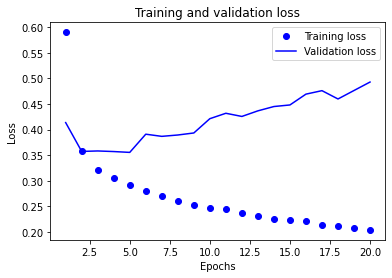

In [13]:
# Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 83.68%


# 7. 학습된 Embedding 레이어 분석

In [15]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

# 학습된 Embedding 레이어 분석
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

1537/1537 - 3s - loss: 0.4930 - accuracy: 0.8368
[0.49301064014434814, 0.8368492722511292]
(10000, 16)


# 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [16]:
# Word2Vec 임베딩 활용하여 성능 개선
import os
import gensim
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

vocab_size = len(word_to_index) + 1
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [17]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=keras.initializers.Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 100)           999800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,003,369
Trainable params: 1,003,369
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 모델 훈련 개시
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
229/229 [==============================] - 4s 10ms/step - loss: 0.6929 - accuracy: 0.5058 - val_loss: 0.6926 - val_accuracy: 0.5017
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.6713 - accuracy: 0.5780 - val_loss: 0.6247 - val_accuracy: 0.6595
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.5252 - accuracy: 0.7455 - val_loss: 0.4499 - val_accuracy: 0.7978
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.4054 - accuracy: 0.8218 - val_loss: 0.4049 - val_accuracy: 0.8208
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3622 - accuracy: 0.8445 - val_loss: 0.3872 - val_accuracy: 0.8303
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3393 - accuracy: 0.8564 - val_loss: 0.3774 - val_accuracy: 0.8360
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3220 - accuracy: 0.8643 - val_loss: 0.3754 - val_accuracy: 0.8377
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


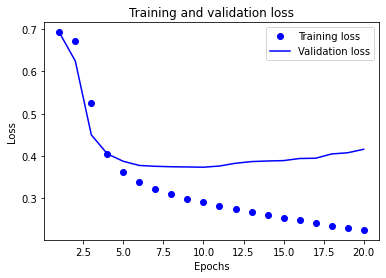

In [19]:
# Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 83.92%


# 별도
여러 모델 시도

In [23]:
from tensorflow.keras.initializers import Constant

# LSTM 파라미터 증가
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, 
                                     word_vector_dim, 
                                     embeddings_initializer=Constant(embedding_matrix),
                                     input_length=54, 
                                     trainable=True))
model1.add(keras.layers.LSTM(10))
model1.add(keras.layers.Dense(10, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 54, 100)           999800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 1,004,361
Trainable params: 1,004,361
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Conv 1D 활용 모델
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid')) 

model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           999800    
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [26]:
# 모델 훈련 개시
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model1.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
229/229 [==============================] - 4s 9ms/step - loss: 0.6388 - accuracy: 0.6108 - val_loss: 0.5250 - val_accuracy: 0.7523
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.4649 - accuracy: 0.7903 - val_loss: 0.4337 - val_accuracy: 0.8063
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3918 - accuracy: 0.8311 - val_loss: 0.3982 - val_accuracy: 0.8250
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3560 - accuracy: 0.8503 - val_loss: 0.3825 - val_accuracy: 0.8351
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3316 - accuracy: 0.8625 - val_loss: 0.3715 - val_accuracy: 0.8377
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3161 - accuracy: 0.8700 - val_loss: 0.3662 - val_accuracy: 0.8403
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3020 - accuracy: 0.8759 - val_loss: 0.3670 - val_accuracy: 0.8429
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


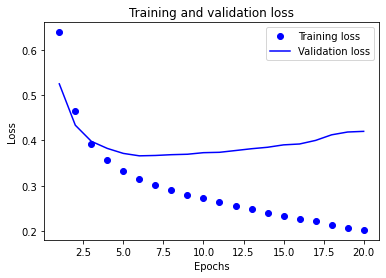

In [27]:
# Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 83.92%


In [29]:
# 모델 훈련 개시
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
229/229 [==============================] - 4s 9ms/step - loss: 0.5974 - accuracy: 0.6684 - val_loss: 0.5130 - val_accuracy: 0.7524
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4632 - accuracy: 0.7841 - val_loss: 0.4447 - val_accuracy: 0.7955
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3990 - accuracy: 0.8226 - val_loss: 0.4132 - val_accuracy: 0.8141
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3596 - accuracy: 0.8434 - val_loss: 0.3912 - val_accuracy: 0.8257
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3316 - accuracy: 0.8573 - val_loss: 0.3846 - val_accuracy: 0.8314
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3106 - accuracy: 0.8674 - val_loss: 0.3741 - val_accuracy: 0.8371
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2933 - accuracy: 0.8764 - val_loss: 0.3771 - val_accuracy: 0.8399
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


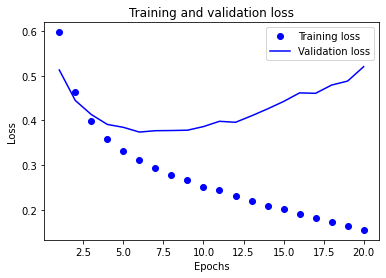

In [30]:
# Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 83.92%
